# KBO Projections Modeling

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend

## Train Test Split

Because the goal of the project is to project full season performance from partial season performance, I will be splitting based on the season column, withholding the partial 2020 season for testing. I will then drop the season column, since it serves more as a nominal column for the sake of the specified projections. I am performing this split before fitting and applying the standard scaler to the rest of the data to avoid data leakage. Then I will apply train_test_split to the pre-2020 data to build models that define the feature relationships for our three response variables.

In [2]:
df = pd.read_csv("KBO_Projections_Data_Modeling.csv")

In [3]:
# split by season, and then drop season column
pd.set_option('mode.chained_assignment',None)
season_2020 = df[df['Season']==2020]
split = df[df['Season']!=2020]
season_2020.drop(['Season'],axis=1,inplace=True)
split.drop(['Season'],axis=1,inplace=True)

In [4]:
# X, y
X = split.drop(['RBI_rate','HR_rate','BA'],axis=1)
X_2020 = season_2020.drop(['RBI_rate','HR_rate','BA'],axis=1)
y = split[['RBI_rate','HR_rate','BA']]
y_2020 = season_2020[['RBI_rate','HR_rate','BA']]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=409)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_2020 = scaler.transform(X_2020)

## Modeling

This is a regression problem. I will try the following models out-of-the-box, and see how they perform. If one is well ahead in terms of performance, I will use that one and tune it. If more than one is very close in terms of performance, I will tune them a bit and see how much performance improvement we can get.

1. RidgeRegression
2. SVR(kernel-'linear')
3. SVR(kernel-'rbf')

In terms of evaluation metrics, I will be using RMSE as my leading indicator. **Note: I also tried Lasso, ElasticNet, and Logit, but the results were either weak or redundant, so I haven't included them here to save space.

In [7]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [8]:
def initial_train_scores(reg):
    print("Training Set Scores: ")
    for y in ['RBI_rate','HR_rate','BA']:
        reg.fit(X_train,y_train[y])
        y_pred = reg.predict(X_train)
        RMSE = mean_squared_error(y_train[y], y_pred, squared=False)
        r2 = r2_score(y_train[y],y_pred)
        MAE = mean_absolute_error(y_train[y], y_pred)
        print(y + ": RMSE: " + str(round(RMSE,3)) + " r2: " + str(round(r2,3)) + " MAE: " + str(round(MAE,3)))

In [9]:
def initial_test_scores(reg):
    print("Test Set Scores: ")
    for y in ['RBI_rate','HR_rate','BA']:
        reg.fit(X_train,y_train[y])
        y_pred = reg.predict(X_test)
        RMSE = mean_squared_error(y_test[y], y_pred, squared=False)
        r2 = r2_score(y_test[y],y_pred)
        MAE = mean_absolute_error(y_test[y], y_pred)
        print(y + ": RMSE: " + str(round(RMSE,3)) + " r2: " + str(round(r2,3)) + " MAE: " + str(round(MAE,3)))

In [10]:
def initial_scores(reg):
    initial_train_scores(reg)
    initial_test_scores(reg)

### RidgeRegression

In [11]:
from sklearn.linear_model import Ridge
ridge = Ridge()

initial_scores(ridge)

Training Set Scores: 
RBI_rate: RMSE: 0.056 r2: 0.532 MAE: 0.028
HR_rate: RMSE: 0.005 r2: 0.944 MAE: 0.002
BA: RMSE: 0.011 r2: 0.99 MAE: 0.005
Test Set Scores: 
RBI_rate: RMSE: 0.081 r2: 0.385 MAE: 0.031
HR_rate: RMSE: 0.007 r2: 0.949 MAE: 0.002
BA: RMSE: 0.014 r2: 0.987 MAE: 0.006


### SVR(kernel-'linear')

In [12]:
from sklearn.svm import SVR
svr_lin = SVR(kernel='linear')

initial_scores(svr_lin)

Training Set Scores: 
RBI_rate: RMSE: 0.07 r2: 0.288 MAE: 0.045
HR_rate: RMSE: 0.084 r2: -18.151 MAE: 0.083
BA: RMSE: 0.063 r2: 0.678 MAE: 0.06
Test Set Scores: 
RBI_rate: RMSE: 0.097 r2: 0.122 MAE: 0.046
HR_rate: RMSE: 0.084 r2: -7.295 MAE: 0.083
BA: RMSE: 0.064 r2: 0.708 MAE: 0.06


### SVR(kernel-'rbf')

In [13]:
svr_rbf = SVR(kernel='rbf')

initial_scores(svr_rbf)

Training Set Scores: 
RBI_rate: RMSE: 0.063 r2: 0.425 MAE: 0.046
HR_rate: RMSE: 0.086 r2: -19.195 MAE: 0.085
BA: RMSE: 0.039 r2: 0.877 MAE: 0.029
Test Set Scores: 
RBI_rate: RMSE: 0.099 r2: 0.088 MAE: 0.049
HR_rate: RMSE: 0.088 r2: -8.095 MAE: 0.085
BA: RMSE: 0.054 r2: 0.793 MAE: 0.031


So, reviewing the above test set scores for each of the three response variables, the best performing model is consistently the __Ridge Regressor__.

RBI_rate: Ridge with an RMSE of 0.081 and r2 of 0.385.

HR_rate: Ridge with an RMSE of 0.007 and r2 of 0.949.

BA: Ridge with and RMSE of 0.014 and r2 of 0.987.

So, I will be using the ridge regressor as the model of choice and tuning it for each of the response variables from here.

## Tuning the Ridge Regressor

Because ridge is not intensely computationally demanding, I will be using a wide GridSearchCV in lieu of Bayesian hyperparameter tuning or RandomSearchCV. I also included some visualizations to show the RMSE in relation to different values of alpha. This was also to narrow the range of my search, while still being open to the possibility that a very large alpha might provide unexpected value.

In [14]:
# define initial range of potential alphas
alphas = [1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
alphas = np.concatenate([alphas, np.arange(1,1001,1)])

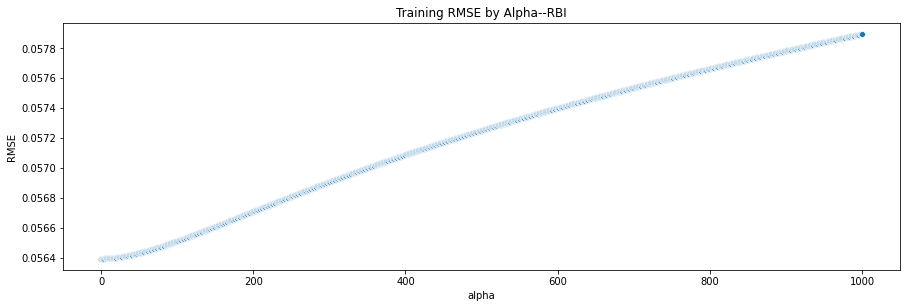

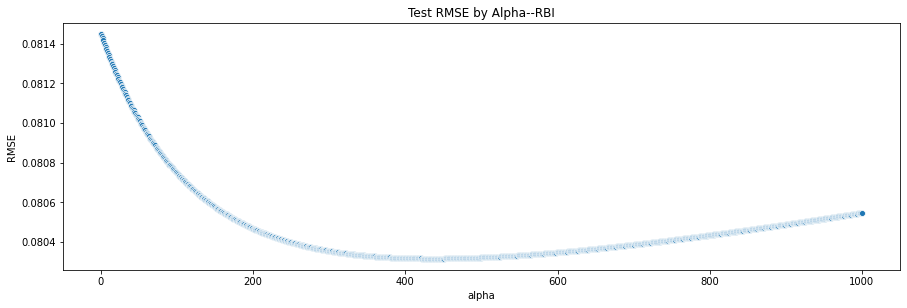

In [15]:
# some visualization to narrow the range of our potential alphas for 'RBI_rate'

scores = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train['RBI_rate'])
    y_pred = ridge.predict(X_train)
    RMSE = mean_squared_error(y_train['RBI_rate'], y_pred, squared=False)
    scores.append(RMSE)

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
_ = sns.scatterplot(x=alphas,y=scores)
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Training RMSE by Alpha--RBI')
plt.axis('tight')
_ = plt.show()

# same as above, but test RMSE
scores = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train['RBI_rate'])
    y_pred = ridge.predict(X_test)
    RMSE = mean_squared_error(y_test['RBI_rate'], y_pred, squared=False)
    scores.append(RMSE)

plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
_ = sns.scatterplot(x=alphas,y=scores)
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Test RMSE by Alpha--RBI')
plt.axis('tight')
_ = plt.show()

In [16]:
# Grid Search for 'RBI_rate'
from joblib import parallel_backend
from sklearn.model_selection import GridSearchCV

rbi_alphas = [1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
rbi_alphas = np.concatenate([rbi_alphas, np.arange(1,600,1)])

params = {
    'alpha':rbi_alphas,
    'fit_intercept':[True,False],
    'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

reg = Ridge()
ridge_cv = GridSearchCV(reg, params, scoring='neg_mean_squared_error')

with parallel_backend('threading',n_jobs=6):
    ridge_cv.fit(X_train,y_train['RBI_rate'])
    print(ridge_cv.best_estimator_)
    print(ridge_cv.best_score_)

Ridge(alpha=6.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='lsqr', tol=0.001)
-0.0033016264679033417


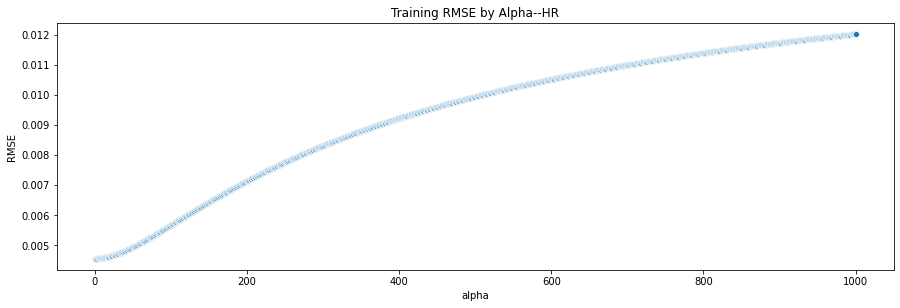

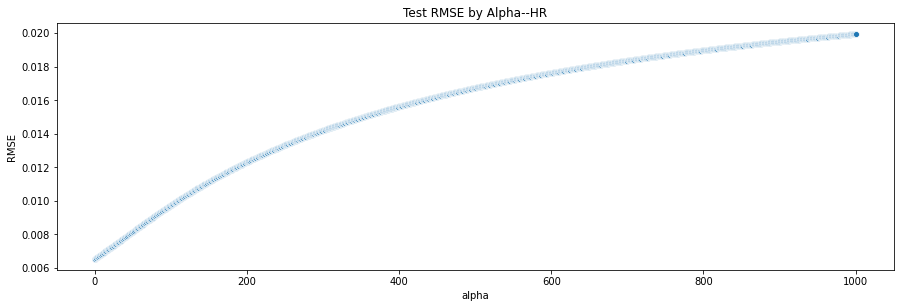

In [17]:
# some visualization to narrow the range of our potential alphas for 'HR_rate'

scores = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train['HR_rate'])
    y_pred = ridge.predict(X_train)
    RMSE = mean_squared_error(y_train['HR_rate'], y_pred, squared=False)
    scores.append(RMSE)

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
_ = sns.scatterplot(x=alphas,y=scores)
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Training RMSE by Alpha--HR')
plt.axis('tight')
_ = plt.show()

# same as above, but test RMSE
scores = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train['HR_rate'])
    y_pred = ridge.predict(X_test)
    RMSE = mean_squared_error(y_test['HR_rate'], y_pred, squared=False)
    scores.append(RMSE)

plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
_ = sns.scatterplot(x=alphas,y=scores)
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Test RMSE by Alpha--HR')
plt.axis('tight')
_ = plt.show()

In [18]:
# Grid Search for 'HR_rate'
from joblib import parallel_backend
from sklearn.model_selection import GridSearchCV

params = {
    'alpha':[1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1],
    'fit_intercept':[True,False],
    'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

reg = Ridge()
ridge_cv = GridSearchCV(reg, params, scoring='neg_mean_squared_error')

with parallel_backend('threading',n_jobs=6):
    ridge_cv.fit(X_train,y_train['RBI_rate'])
    print(ridge_cv.best_estimator_)
    print(ridge_cv.best_score_)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='lsqr', tol=0.001)
-0.0033017128702493266


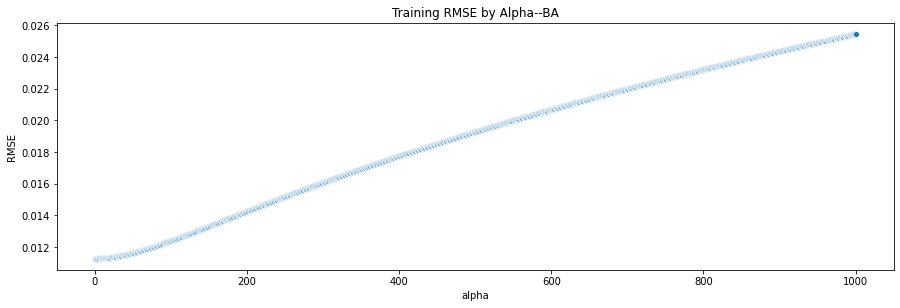

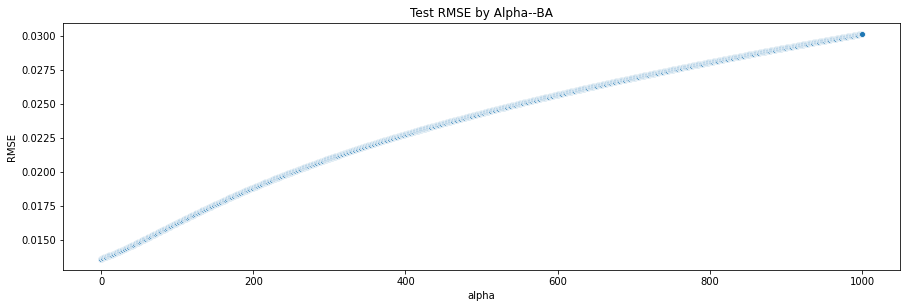

In [19]:
# some visualization to narrow the range of our potential alphas for 'BA'

scores = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train['BA'])
    y_pred = ridge.predict(X_train)
    RMSE = mean_squared_error(y_train['BA'], y_pred, squared=False)
    scores.append(RMSE)

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
_ = sns.scatterplot(x=alphas,y=scores)
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Training RMSE by Alpha--BA')
plt.axis('tight')
_ = plt.show()

# same as above, but test RMSE
scores = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train['BA'])
    y_pred = ridge.predict(X_test)
    RMSE = mean_squared_error(y_test['BA'], y_pred, squared=False)
    scores.append(RMSE)

plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
_ = sns.scatterplot(x=alphas,y=scores)
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Test RMSE by Alpha--BA')
plt.axis('tight')
_ = plt.show()

In [20]:
# Grid Search for 'BA'
from joblib import parallel_backend
from sklearn.model_selection import GridSearchCV

params = {
    'alpha':[1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1],
    'fit_intercept':[True,False],
    'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

reg = Ridge()
ridge_cv = GridSearchCV(reg, params, scoring='neg_mean_squared_error')

with parallel_backend('threading',n_jobs=6):
    ridge_cv.fit(X_train,y_train['BA'])
    print(ridge_cv.best_estimator_)
    print(ridge_cv.best_score_)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='sag', tol=0.001)
-0.00013963189743740277


In [21]:
# check each model's RMSE against the test set:
RBI_model = Ridge(alpha=6.0, solver='lsqr')
HR_model = Ridge(alpha=1, solver='sag')
BA_model = Ridge(alpha=1e-09,solver='sag')

RBI_model.fit(X_train,y_train['RBI_rate'])
y_pred = RBI_model.predict(X_test)
RMSE = mean_squared_error(y_test['RBI_rate'], y_pred, squared=False)
print("The RBI model's test set RMSE is: " + str(round(RMSE,3)))

HR_model.fit(X_train,y_train['HR_rate'])
y_pred = HR_model.predict(X_test)
RMSE = mean_squared_error(y_test['HR_rate'], y_pred, squared=False)
print("The HR model's test set RMSE is: " + str(round(RMSE,3)))

BA_model.fit(X_train,y_train['BA'])
y_pred = BA_model.predict(X_test)
RMSE = mean_squared_error(y_test['BA'], y_pred, squared=False)
print("The BA model's test set RMSE is: " + str(round(RMSE,3)))

The RBI model's test set RMSE is: 0.081
The HR model's test set RMSE is: 0.007
The BA model's test set RMSE is: 0.014


## Conclusion

So, based on the above grid searches, here are our tuned models for each of the three response variables.

RBI_rate: Ridge(alpha=6.0, solver='lsqr')

HR_rate: Ridge(alpha=1, solver='sag')

BA: Ridge(alpha=1e-09,solver='sag')

Now we have functions that define the relationships between our features and each of the three response variables!

I use these below to export projections for 2020 to CSV.

In [22]:
rbi = RBI_model.predict(X_2020)
hr = HR_model.predict(X_2020)
ba = BA_model.predict(X_2020)

export_df = pd.DataFrame(data=[rbi,hr,ba],index=['RBI_rate','HR_rate','BA']).T
export_df.to_csv('2020_projections.csv')